### Tree / Forest Challenges

You can examine the decision paths of an `sklearn` tree by generating `pydot` graphs as in the `sklearn` [documentation](http://scikit-learn.org/stable/modules/tree.html). It's sometimes tricky to get `pydot` working; see below for a possible install plan.


#### Challenge 1

For the house representatives data set, fit and evaluate a decision tree classifier. Examine the rules your tree uses.

##### Solution
I loaded the dataset and coded the responses with numbers.
* y: 2  
* ?: 1  
* n: 0 

This lets the tree decide whether to group non-votes with yesses or nos. Then I trained a classifer to predict a representitive's party from their voting record.  

Accurding to the feature_importance attrivute, the five most important features were:
1. physician-fee-freeze: 0.894
2. synfuels-corporation-cutback: 0.031
3. anti-satellite-test-ban: 0.021
4. adoption-of-the-budget-resolution: 0.016
5. mx-missile: 0.014

The physician-fee-freeze bill is extremely useful for classification.  A vote for the bill indicated that the representitive was a democrat, and a vote against it indicated that the representitive was a republican.  When a representitive abstained from this vote, the education-spending bill helped determine which party they belonged to.

Representitives who voted for physician-fee-freeze and voted for synfuels-corporation-cutback were very likely to be democrats.  Those who voted for physician-fee-freeze but did not vote for synfuels-corporation-cutback where difficult to classify.  

I wrote a function to traverse the decision tree and find the set of rules that lead to each leaf node.  My function adapts the code [here](http://scikit-learn.org/dev/auto_examples/tree/unveil_tree_structure.html), extending it to collect the rules for each leaf instead of printing the rule at each node.


In [174]:
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

colnames = ['party','handicapped-infants','water-project-cost-sharing','adoption-of-the-budget-resolution']+\
        ['physician-fee-freeze','el-salvador-aid','religious-groups-in-schools','anti-satellite-test-ban']+\
        ['aid-to-nicaraguan-contras','mx-missile','immigration','synfuels-corporation-cutback','education-spending']+\
        ['superfund-right-to-sue','crime','duty-free-exports','export-administration-act-south-africa']
representatives = pd.read_csv("house-votes-84.data", header=None)

representatives = representatives.replace('y',2)
representatives = representatives.replace('n',0)
representatives = representatives.replace('?',1)

representatives = representatives.replace('republican','r')
representatives = representatives.replace('democrat','d')

representatives.columns = colnames
representatives.head()



,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,r,0,2,0,2,2,2,0,0,0,2,1,2,2,2,0,2
1,r,0,2,0,2,2,2,0,0,0,0,0,2,2,2,0,1
2,d,1,2,2,1,2,2,0,0,0,0,2,0,2,2,0,0
3,d,0,2,2,0,1,2,0,0,0,0,2,0,2,0,0,2
4,d,2,2,2,0,2,2,0,0,0,0,2,1,2,2,2,2


In [175]:
X = representatives.iloc[:,1:]
y = representatives.iloc[:,0]

X.head()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,0,2,0,2,2,2,0,0,0,2,1,2,2,2,0,2
1,0,2,0,2,2,2,0,0,0,0,0,2,2,2,0,1
2,1,2,2,1,2,2,0,0,0,0,2,0,2,2,0,0
3,0,2,2,0,1,2,0,0,0,0,2,0,2,0,0,2
4,2,2,2,0,2,2,0,0,0,0,2,1,2,2,2,2


In [176]:
dectree = DecisionTreeClassifier(max_depth=3)
dectree.fit(X,y)

# Print features in descending order of importance
for name, imp in sorted(zip(X.columns, dectree.feature_importances_), key=lambda x: abs(x[1]))[::-1]:
    print "%s: %.3f"%(name, imp)

physician-fee-freeze: 0.941
synfuels-corporation-cutback: 0.030
adoption-of-the-budget-resolution: 0.016
education-spending: 0.011
duty-free-exports: 0.003
export-administration-act-south-africa: 0.000
crime: 0.000
superfund-right-to-sue: 0.000
immigration: 0.000
mx-missile: 0.000
aid-to-nicaraguan-contras: 0.000
anti-satellite-test-ban: 0.000
religious-groups-in-schools: 0.000
el-salvador-aid: 0.000
water-project-cost-sharing: 0.000
handicapped-infants: 0.000


In [177]:
# Traverse decision tree and find set of rules for each leaf node
def print_rules(estimator, featnames):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold
    value = estimator.tree_.value
    node_rules = ['']*n_nodes
    node_counts = dectree.tree_.n_node_samples

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes)
    parent = np.zeros(shape=n_nodes) - 1
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))

            featname = featnames[feature[node_id]]
            
            node_rules[children_left[node_id]] = node_rules[node_id] + ' & (%s <= %s)'%(featname, threshold[node_id])
            node_rules[children_right[node_id]] = node_rules[node_id] + ' & (%s > %s)'%(featname, threshold[node_id])
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has %d leaves"
          % sum(is_leaves))
    for i in range(n_nodes):
        if is_leaves[i]:
            ct = node_counts[i]
            node_value = estimator.classes_[-1-np.argmax(value[i][0])]
            print "%5s if %s [%d]"%(node_value, node_rules[i][3:], ct)

In [178]:
# Print out the leaf node rules
print_rules(dectree, X.columns)

The binary tree structure has 8 leaves
    r if (physician-fee-freeze <= 1.5) & (physician-fee-freeze <= 0.5) & (adoption-of-the-budget-resolution <= 0.5) [25]
    r if (physician-fee-freeze <= 1.5) & (physician-fee-freeze <= 0.5) & (adoption-of-the-budget-resolution > 0.5) [222]
    r if (physician-fee-freeze <= 1.5) & (physician-fee-freeze > 0.5) & (education-spending <= 0.5) [6]
    d if (physician-fee-freeze <= 1.5) & (physician-fee-freeze > 0.5) & (education-spending > 0.5) [5]
    d if (physician-fee-freeze > 1.5) & (synfuels-corporation-cutback <= 1.5) & (duty-free-exports <= 1.5) [132]
    d if (physician-fee-freeze > 1.5) & (synfuels-corporation-cutback <= 1.5) & (duty-free-exports > 1.5) [13]
    d if (physician-fee-freeze > 1.5) & (synfuels-corporation-cutback > 1.5) & (adoption-of-the-budget-resolution <= 0.5) [23]
    r if (physician-fee-freeze > 1.5) & (synfuels-corporation-cutback > 1.5) & (adoption-of-the-budget-resolution > 0.5) [9]


In [179]:
print dectree.classes_

['d' 'r']


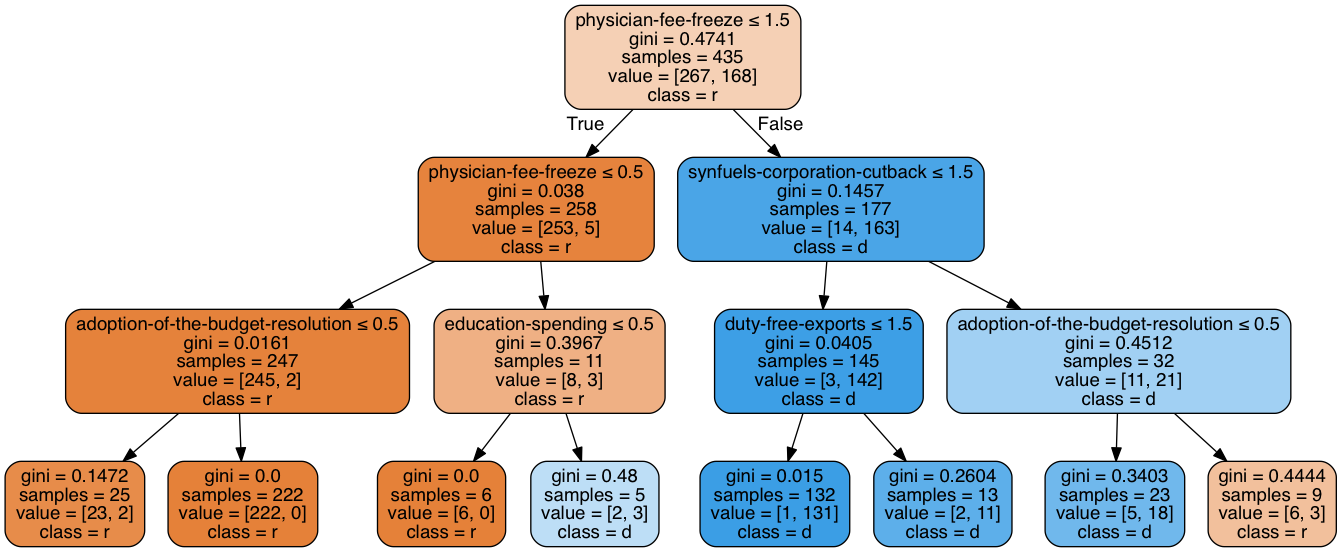

In [180]:
from sklearn.externals.six import StringIO  
from sklearn import tree
import pydot
from IPython.display import Image
dot_data = StringIO()
tree.export_graphviz(dectree, out_file=dot_data,
                         feature_names=X.columns,
                         class_names=list(set(y)),
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

#### Challenge 2

Fit and evaluate a decision tree classifier for your movie dataset. Examine the rules your tree uses.

This classifier is only partially successful.  Some nodes appear to have clean separations, for instance the rule  
PG-13 if (Budget > 117500000.0) & (Runtime > 111.0) & (Month > 3.5)  
correctly classifies 13 movies.  However, the largest leaf node  
PG if (Budget <= 117500000.0) & (Budget <= 48000000.0) & (DomesticTotalGross <= 120863848.0)  
Is basically just a guess.  Of the 34 cases, 2 are R, 13 are PG-13 and 19 are PG.

In [181]:
movies = pd.read_csv('2013_movies.csv')
movies['Month'] = movies['ReleaseDate'].astype(np.datetime64).apply(lambda x: x.month)
movies['Weekday'] = movies['ReleaseDate'].astype(np.datetime64).apply(lambda x: x.weekday())
movies.drop(movies['Rating']=='G', axis=0)
movies.dropna(axis=0,how='any', inplace=True)
movies.head()

from patsy import dmatrices
y, X = dmatrices('Rating ~ Budget + DomesticTotalGross + Runtime + Month + Weekday', data=movies, return_type='dataframe')
y = movies['Rating']

dectree = DecisionTreeClassifier(max_depth=3)
dectree.fit(X,y)

from sklearn.metrics import precision_score, recall_score
print "Classifier performance"
print "Accuracy: %.3f"%dectree.score(X,y)
for c in set(y):
    print "%s precision: %.3f, recall: %.3f"%(c, precision_score(y==c,dectree.predict(X)==c), recall_score(y==c,dectree.predict(X)==c))
print ""
    
# Print features in descending order of importance
print "Feature Importance:"
for name, imp in sorted(zip(X.columns, dectree.feature_importances_), key=lambda x: abs(x[1]))[::-1]:
    print "%s: %.3f"%(name, imp)

Classifier performance
Accuracy: 0.690
R precision: 0.625, recall: 0.758
PG-13 precision: 0.920, recall: 0.575
PG precision: 0.545, recall: 0.857

Feature Importance:
Budget: 0.628
Runtime: 0.247
DomesticTotalGross: 0.084
Month: 0.042
Weekday: 0.000
Intercept: 0.000


In [182]:
# Print out the leaf node rules
print_rules(dectree, X.columns)

The binary tree structure has 8 leaves
   PG if (Budget <= 117500000.0) & (Budget <= 48000000.0) & (DomesticTotalGross <= 120863848.0) [34]
   PG if (Budget <= 117500000.0) & (Budget <= 48000000.0) & (DomesticTotalGross > 120863848.0) [6]
    R if (Budget <= 117500000.0) & (Budget > 48000000.0) & (Runtime <= 115.0) [17]
PG-13 if (Budget <= 117500000.0) & (Budget > 48000000.0) & (Runtime > 115.0) [9]
PG-13 if (Budget > 117500000.0) & (Runtime <= 111.0) & (Budget <= 132500000.0) [3]
    R if (Budget > 117500000.0) & (Runtime <= 111.0) & (Budget > 132500000.0) [3]
    R if (Budget > 117500000.0) & (Runtime > 111.0) & (Month <= 3.5) [2]
PG-13 if (Budget > 117500000.0) & (Runtime > 111.0) & (Month > 3.5) [13]


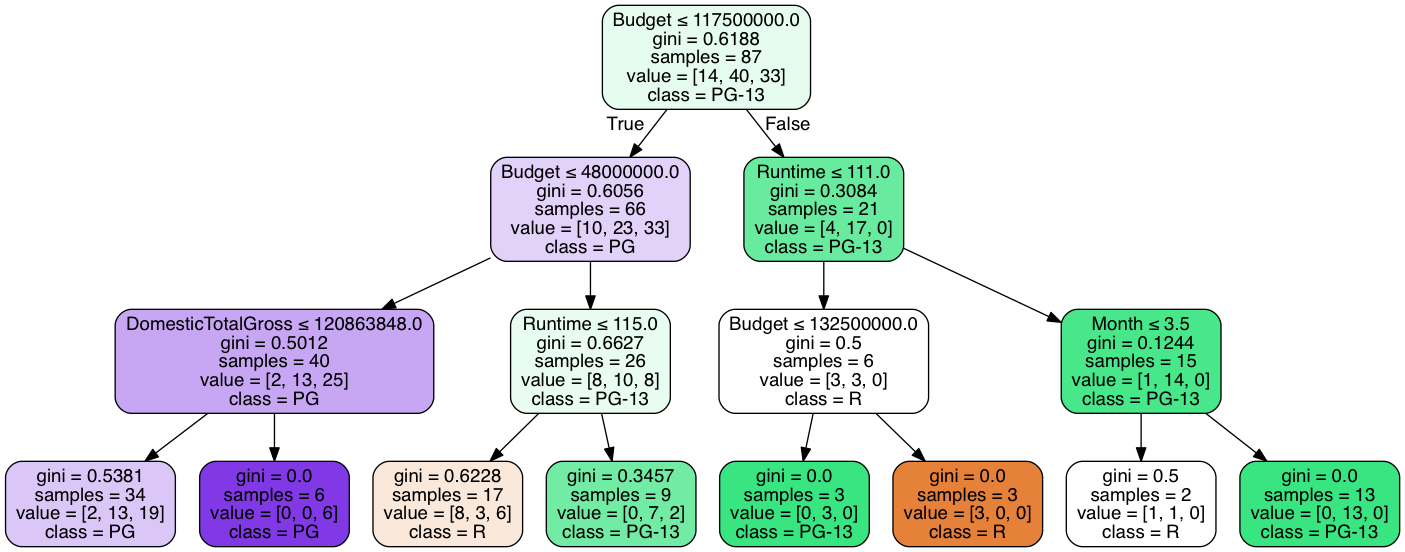

In [183]:
dot_data = StringIO()
tree.export_graphviz(dectree, out_file=dot_data,
                         feature_names=X.columns,
                         class_names=list(set(y)),
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

#### Challenge 3 (Optional but recommended)

Tackle the [Titanic Survivors kaggle competition](https://www.kaggle.com/c/titanic-gettingStarted) with decision trees. Look at your splits; how does your tree decide?

### Installing pydot for the challenges:

Note: Uninstall pydot if you already installed it but it's not working

    pip uninstall pydot

Otherwise, you can start here:

    pip uninstall pyparsing

    pip install -Iv
    https://pypi.python.org/packages/source/p/pyparsing/pyparsing-1.5.7.tar.gz#md5=9be0fcdcc595199c646ab317c1d9a709

    pip install pydot

    brew install graphviz